# Predict Median Household Income

This notebook shows how to use supervised machine learning to predict median household income for block groups in California using American Community Survey 2017-2021 5-year data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import joblib

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
census_data = pd.read_csv('census_data.csv')
census_data.head(3)

,GEO_ID_Geography,state,county,tract,block group,B01003_001E_Estimate_Total,B01002_001E_Estimate_Median_age_--_Total,B01001_001E_Estimate_Total,B01001_002E_Estimate_Total_Male,B01001_026E_Estimate_Total_Female,B03002_001E_Estimate_Total,B03002_002E_Estimate_Total_Not_Hispanic_or_Latino,B03002_003E_Estimate_Total_Not_Hispanic_or_Latino_White_alone,B03002_004E_Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone,B03002_005E_Estimate_Total_Not_Hispanic_or_Latino_American_Indian_and_Alaska_Native_alone,B03002_006E_Estimate_Total_Not_Hispanic_or_Latino_Asian_alone,B03002_007E_Estimate_Total_Not_Hispanic_or_Latino_Native_Hawaiian_and_Other_Pacific_Islander_alone,B03002_008E_Estimate_Total_Not_Hispanic_or_Latino_Some_other_race_alone,B03002_009E_Estimate_Total_Not_Hispanic_or_Latino_Two_or_more_races,B03002_012E_Estimate_Total_Hispanic_or_Latino,B99162_001E_Estimate_Total,B99162_002E_Estimate_Total_Speak_only_English,B99162_003E_Estimate_Total_Speak_other_languages,B19013_001E_Estimate_Median_household_income_in_the_past_12_months_(in_2021_inflation-adjusted_dollars),C17002_001E_Estimate_Total,C17002_002E_Estimate_Total_Under_.50,C17002_003E_Estimate_Total_.50_to_.99,C17002_004E_Estimate_Total_1.00_to_1.24,C17002_005E_Estimate_Total_1.25_to_1.49,C17002_006E_Estimate_Total_1.50_to_1.84,C17002_007E_Estimate_Total_1.85_to_1.99,C17002_008E_Estimate_Total_2.00_and_over,B07201_001E_Estimate_Total,B07201_002E_Estimate_Total_Same_house_1_year_ago,B07201_003E_Estimate_Total_Different_house_in_United_States_1_year_ago,B07201_014E_Estimate_Total_Abroad_1_year_ago,B08301_001E_Estimate_Total,"B08301_002E_Estimate_Total_Car,_truck,_or_van",B08301_010E_Estimate_Total_Public_transportation_(excluding_taxicab),B08301_016E_Estimate_Total_Taxicab,B08301_017E_Estimate_Total_Motorcycle,B08301_018E_Estimate_Total_Bicycle,B08301_019E_Estimate_Total_Walked,B08301_020E_Estimate_Total_Other_means,B08301_021E_Estimate_Total_Worked_from_home,B25003_001E_Estimate_Total,B25003_002E_Estimate_Total_Owner_occupied,B25003_003E_Estimate_Total_Renter_occupied,B01001_002E_Estimate_Total_Male_P,B01001_026E_Estimate_Total_Female_P,B03002_002E_Estimate_Total_Not_Hispanic_or_Latino_P,B03002_003E_Estimate_Total_Not_Hispanic_or_Latino_White_alone_P,B03002_004E_Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone_P,B03002_005E_Estimate_Total_Not_Hispanic_or_Latino_American_Indian_and_Alaska_Native_alone_P,B03002_006E_Estimate_Total_Not_Hispanic_or_Latino_Asian_alone_P,B03002_007E_Estimate_Total_Not_Hispanic_or_Latino_Native_Hawaiian_and_Other_Pacific_Islander_alone_P,B03002_008E_Estimate_Total_Not_Hispanic_or_Latino_Some_other_race_alone_P,B03002_009E_Estimate_Total_Not_Hispanic_or_Latino_Two_or_more_races_P,B03002_012E_Estimate_Total_Hispanic_or_Latino_P,B99162_002E_Estimate_Total_Speak_only_English_P,B99162_003E_Estimate_Total_Speak_other_languages_P,C17002_002E_Estimate_Total_Under_.50_P,C17002_003E_Estimate_Total_.50_to_.99_P,C17002_004E_Estimate_Total_1.00_to_1.24_P,C17002_005E_Estimate_Total_1.25_to_1.49_P,C17002_006E_Estimate_Total_1.50_to_1.84_P,C17002_007E_Estimate_Total_1.85_to_1.99_P,C17002_008E_Estimate_Total_2.00_and_over_P,B07201_002E_Estimate_Total_Same_house_1_year_ago_P,B07201_003E_Estimate_Total_Different_house_in_United_States_1_year_ago_P,B07201_014E_Estimate_Total_Abroad_1_year_ago_P,"B08301_002E_Estimate_Total_Car,_truck,_or_van_P",B08301_010E_Estimate_Total_Public_transportation_(excluding_taxicab)_P,B08301_016E_Estimate_Total_Taxicab_P,B08301_017E_Estimate_Total_Motorcycle_P,B08301_018E_Estimate_Total_Bicycle_P,B08301_019E_Estimate_Total_Walked_P,B08301_020E_Estimate_Total_Other_means_P,B08301_021E_Estimate_Total_Worked_from_home_P,B25003_002E_Estimate_Total_Owner_occupied_P,B25003_003E_Estimate_Total_Renter_occupied_P
0,1500000US060014001001,6,1,400100,1,1963,47.1,1963.0,1054.0,909.0,1963.0,1847.0,1429.0,44.0,0.0,257.0,0.0,17.0,100.0,116.0,1940.0,1602.0,338.0,190179,1963.0,29.0,41.0,83.0,37.0,33.0,20.0,1720.0,1950.0,17

## Define Label and Features

The label is median household income, which is missing for some block groups. A predictive model could be valuable for filling those missing values.

For this analysis, the label and all predictive features are numeric (not categorical).

In [4]:
label = ['B19013_001E_Estimate_Median_household_income_in_the_past_12_months_(in_2021_inflation-adjusted_dollars)']
features = [
    'B01002_001E_Estimate_Median_age_--_Total',
    'B01001_026E_Estimate_Total_Female_P',
    'B03002_003E_Estimate_Total_Not_Hispanic_or_Latino_White_alone_P',
    'B03002_004E_Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone_P',
    'B03002_005E_Estimate_Total_Not_Hispanic_or_Latino_American_Indian_and_Alaska_Native_alone_P',
    'B03002_006E_Estimate_Total_Not_Hispanic_or_Latino_Asian_alone_P',
    'B03002_007E_Estimate_Total_Not_Hispanic_or_Latino_Native_Hawaiian_and_Other_Pacific_Islander_alone_P',
    'B03002_008E_Estimate_Total_Not_Hispanic_or_Latino_Some_other_race_alone_P',
    'B03002_009E_Estimate_Total_Not_Hispanic_or_Latino_Two_or_more_races_P',
    'B03002_012E_Estimate_Total_Hispanic_or_Latino_P',
    'B99162_002E_Estimate_Total_Speak_only_English_P',
    'C17002_002E_Estimate_Total_Under_.50_P',
    'C17002_003E_Estimate_Total_.50_to_.99_P',
    'C17002_004E_Estimate_Total_1.00_to_1.24_P',
    'C17002_005E_Estimate_Total_1.25_to_1.49_P',
    'C17002_006E_Estimate_Total_1.50_to_1.84_P',
    'C17002_007E_Estimate_Total_1.85_to_1.99_P',
    'C17002_008E_Estimate_Total_2.00_and_over_P',
    'B07201_002E_Estimate_Total_Same_house_1_year_ago_P',
    'B08301_002E_Estimate_Total_Car,_truck,_or_van_P',
    'B08301_010E_Estimate_Total_Public_transportation_(excluding_taxicab)_P',
    'B08301_019E_Estimate_Total_Walked_P',
    'B08301_021E_Estimate_Total_Worked_from_home_P',
    'B25003_003E_Estimate_Total_Renter_occupied_P'
]

## Explore the Data

First, we will look at summary statistics and counts of missing data for the label and features.

In [5]:
census_data[label + features].describe().apply(lambda s: s.apply('{0:.2f}'.format))

,B19013_001E_Estimate_Median_household_income_in_the_past_12_months_(in_2021_inflation-adjusted_dollars),B01002_001E_Estimate_Median_age_--_Total,B01001_026E_Estimate_Total_Female_P,B03002_003E_Estimate_Total_Not_Hispanic_or_Latino_White_alone_P,B03002_004E_Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone_P,B03002_005E_Estimate_Total_Not_Hispanic_or_Latino_American_Indian_and_Alaska_Native_alone_P,B03002_006E_Estimate_Total_Not_Hispanic_or_Latino_Asian_alone_P,B03002_007E_Estimate_Total_Not_Hispanic_or_Latino_Native_Hawaiian_and_Other_Pacific_Islander_alone_P,B03002_008E_Estimate_Total_Not_Hispanic_or_Latino_Some_other_race_alone_P,B03002_009E_Estimate_Total_Not_Hispanic_or_Latino_Two_or_more_races_P,B03002_012E_Estimate_Total_Hispanic_or_Latino_P,B99162_002E_Estimate_Total_Speak_only_English_P,C17002_002E_Estimate_Total_Under_.50_P,C17002_003E_Estimate_Total_.50_to_.99_P,C17002_004E_Estimate_Total_1.00_to_1.24_P,C17002_005E_Estimate_Total_1.25_to_1.49_P,C17002_006E_Estimate_Total_1.50_to_1.84_P,C17002_007E_Estimate_Total_1.85_to_1.99_P,C17002_008E_Estimate_Total_2.00_and_over_P,B07201_002E_Estimate_Total_Same_house_1_year_ago_P,"B08301_002E_Estimate_Total_Car,_truck,_or_van_P",B08301_010E_Estimate_Total_Public_transportation_(excluding_taxicab)_P,B08301_019E_Estimate_Total_Walked_P,B08301_021E_Estimate_Total_Worked_from_home_P,B25003_003E_Estimate_Total_Renter_occupied_P
count,25607.00,25607.00,25516.00,25516.00,25516.00,25516.00,25516.00,25516.00,25516.00,25516.00,25516.00,25516.00,25466.00,25466.00,25466.00,25466.00,25466.00,25466.00,25466.00,24779.00,25471.00,25471.00,25471.00,25471.00,25459.00
mean,-39039504.91,-2603415.45,0.50,0.39,0.05,0.00,0.14,0.00,0.00,0.04,0.37,0.58,0.06,0.07,0.04,0.04,0.06,0.02,0.72,0.88,0.80,0.04,0.02,0.11,0.43
std,156727483.71,41580359.13,0.07,0.27,0.10,0.02,0.18,0.02,0.02,0.04,0.28,0.25,0.07,0.08,0.06,0.06,0.07,0.04,0.20,0.10,0.16,0.07,0.06,0.11,0.28
min,-666666666.00,-666666666.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,55187.00,32.50,0.46,0.14,0.00,0.00,0.02,0.00,0.00,0.00,0.13,0.39,0.01,0.01,0.00,0.00,0.01,0.00,0.59,0.84,0.73,0.00,0.00,0.04,0.19
50%,82553.00,37.90,0.50,0.36,0.01,0.00,0.07,0.00,0.00,0.02,0.30,0.61,0.03,0.04,0.02,0.02,0.03,0.01,0.76,0.91,0.84,0.00,0.00,0.09,0.39
75%,117942.00,45.10,0.54,0.61,0.06,0.00,0.20,0.00,0.00,0.05,0.58,0.79,0.08,0.09,0.05,0.05,0.08,0.03,0.88,0.95,0.91,0.05,0.03,0.17,0.65
max,250001.00,85.80,1.00,1.00,1.00,1.00,1.00,0.37,0.53,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.64,1.00,1.00,1.00,0.81,1.00,1.00,1.00


In [6]:
census_data[census_data[label[0]] == -666666666][label[0]].value_counts()

-666666666    1503
Name: B19013_001E_Estimate_Median_household_income_in_the_past_12_months_(in_2021_inflation-adjusted_dollars), dtype: int64

In [7]:
census_data[census_data[features[0]] == -666666666][features[0]].value_counts()

-666666666.0    100
Name: B01002_001E_Estimate_Median_age_--_Total, dtype: int64

In [8]:
census_data[label + features].isna().sum()

B19013_001E_Estimate_Median_household_income_in_the_past_12_months_(in_2021_inflation-adjusted_dollars)      0
B01002_001E_Estimate_Median_age_--_Total                                                                     0
B01001_026E_Estimate_Total_Female_P                                                                         91
B03002_003E_Estimate_Total_Not_Hispanic_or_Latino_White_alone_P                                             91
B03002_004E_Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone_P                         91
B03002_005E_Estimate_Total_Not_Hispanic_or_Latino_American_Indian_and_Alaska_Native_alone_P                 91
B03002_006E_Estimate_Total_Not_Hispanic_or_Latino_Asian_alone_P                                             91
B03002_007E_Estimate_Total_Not_Hispanic_or_Latino_Native_Hawaiian_and_Other_Pacific_Islander_alone_P        91
B03002_008E_Estimate_Total_Not_Hispanic_or_Latino_Some_other_race_alone_P                                   91
B

Median income and median age both have missing values indicated by the value '-666666666'. Additionally, the other features have null values constituting a small percent of the data. We will address the missing data before continuing with exploratory data analysis.

For the features, we will replace missing values with the median value of the feature (assuming some features may be skewed, and therefore median may be more of a "typical" value than the mean).

In [9]:
census_data_cleaned = census_data.copy()
for i in features:
    census_data_cleaned[i] = census_data_cleaned[i].fillna(census_data_cleaned[i].median())
    census_data_cleaned.loc[census_data_cleaned[i] == -666666666, i] = census_data_cleaned[i].median()

For the label, we will pull out the records with a missing median income for use later as a set of new data to predict.

In [10]:
census_data_cleaned.loc[census_data_cleaned[label[0]] == -666666666, label[0]] = np.nan
census_data_new = census_data_cleaned[census_data_cleaned[label[0]].isnull()]
census_data_cleaned = census_data_cleaned[census_data_cleaned[label[0]].notnull()]

Next, create histograms and examine the distribution of each feature to check for normality and skew.

/var/folders/9r/gxxgh57x3ylgd087vqc8zz4m0000gn/T/ipykernel_97382/417270599.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(3, 2))


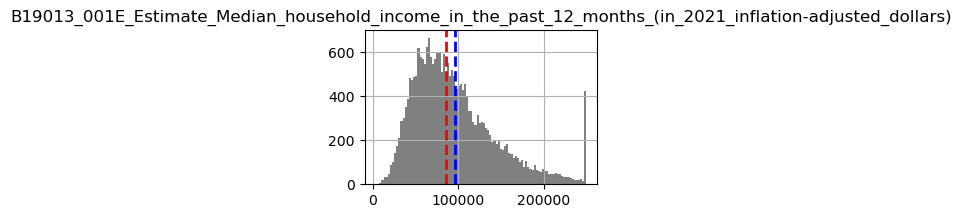

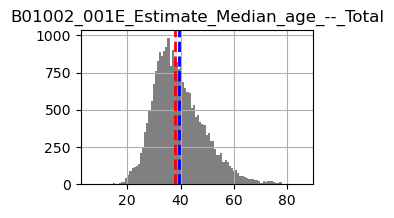

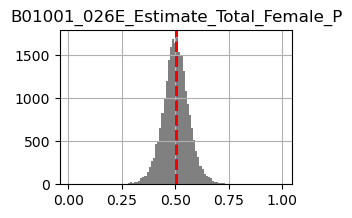

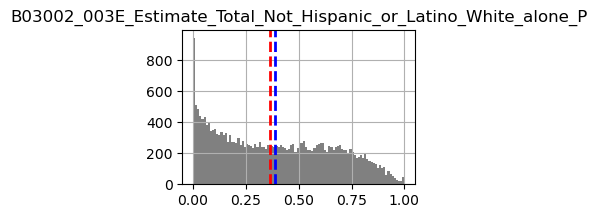

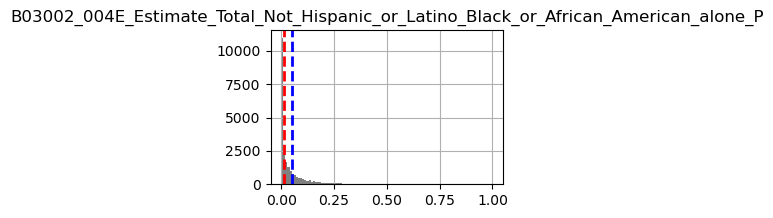

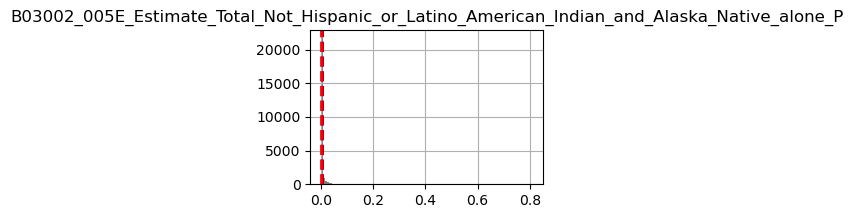

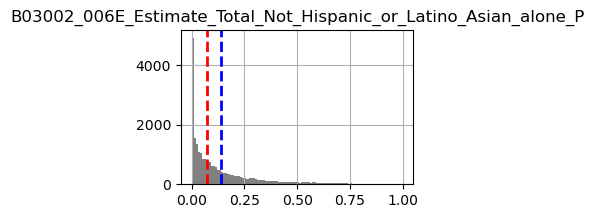

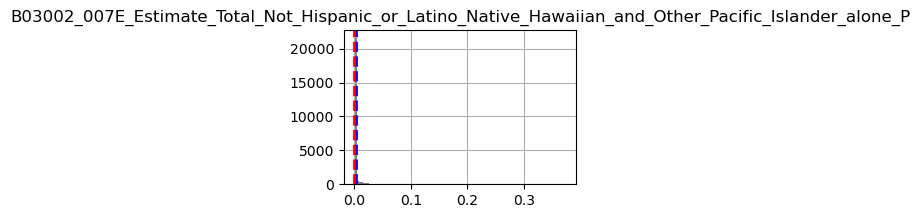

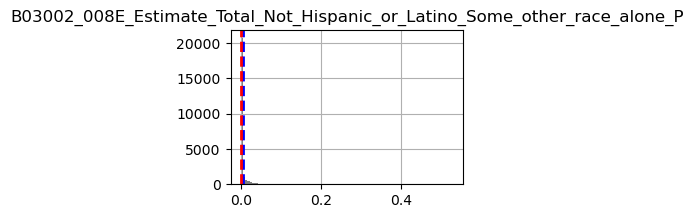

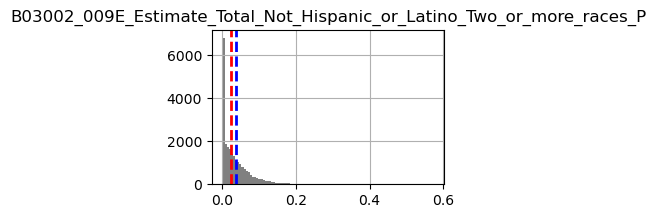

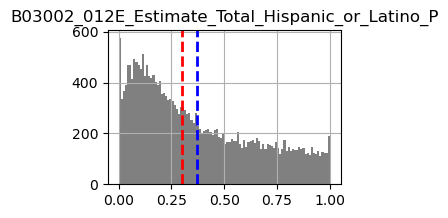

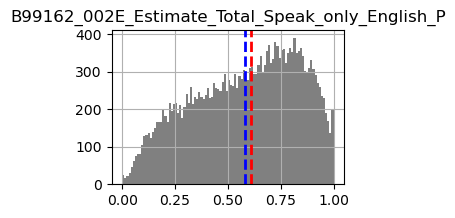

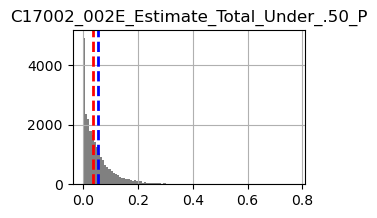

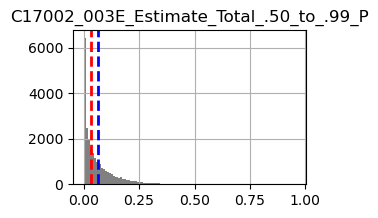

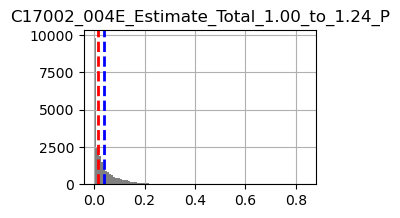

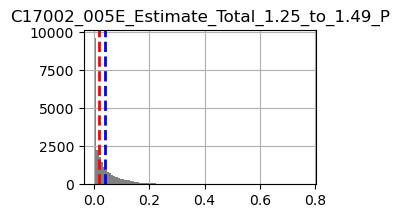

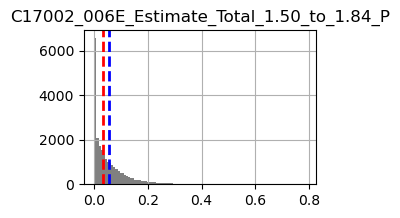

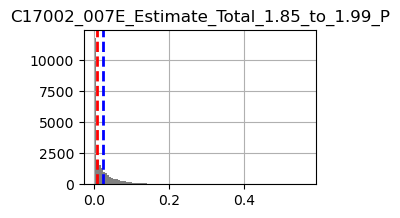

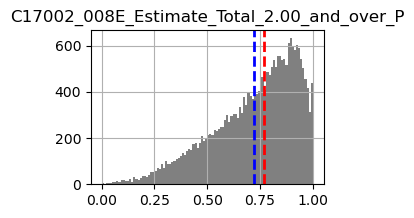

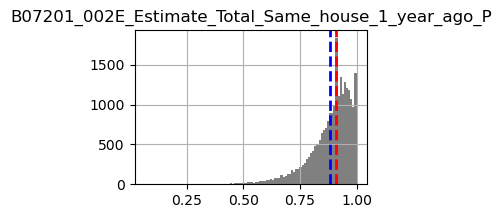

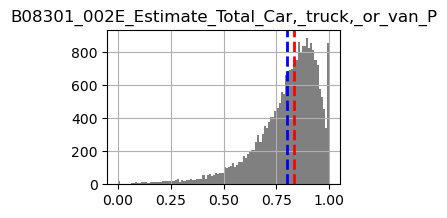

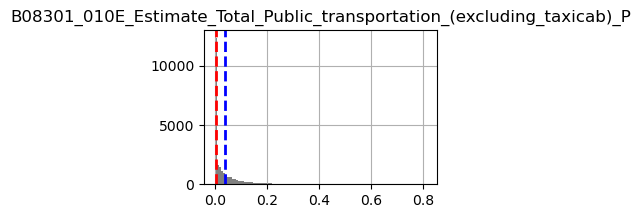

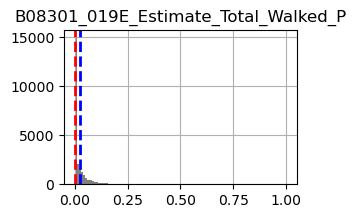

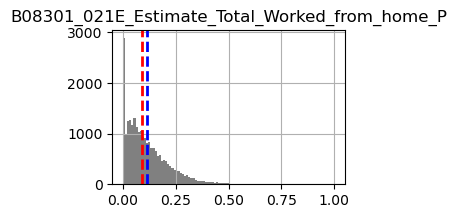

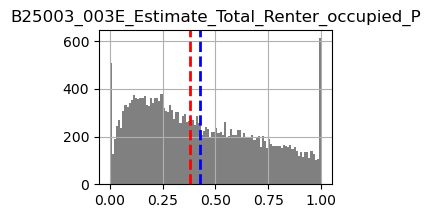

In [11]:
for i in label + features:
    fig = plt.figure(figsize=(3, 2))
    ax = fig.gca()
    feature = census_data_cleaned[i]
    feature.hist(bins=100, ax=ax, color='gray')
    ax.axvline(feature.mean(), color='blue', linestyle='dashed', linewidth=2)
    ax.axvline(feature.median(), color='red', linestyle='dashed', linewidth=2)
    ax.set_title(i)
plt.show()

Some features have a close to normal distribution, while others are skewed right or left. Notably, the label appears to be capped around $250,000.

In [12]:
census_data_cleaned[label[0]][census_data_cleaned[label[0]] >= 249000].value_counts()

250001.0    406
249306.0      1
249659.0      1
249901.0      1
249679.0      1
249519.0      1
Name: B19013_001E_Estimate_Median_household_income_in_the_past_12_months_(in_2021_inflation-adjusted_dollars), dtype: int64

We will drop observations at the income cap to ensure the model doesn't over-predict the number of block groups at this value.

In [13]:
census_data_cleaned = census_data_cleaned[census_data_cleaned[label[0]] < 250000]

Now, create scatterplots to examine potential associations between the features and the label. We will use a random sample of the data to improve visualization.

/var/folders/9r/gxxgh57x3ylgd087vqc8zz4m0000gn/T/ipykernel_97382/1506108243.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(3, 2))


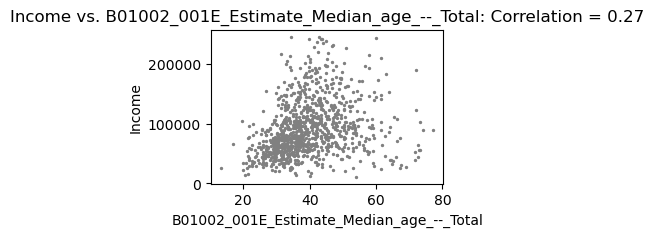

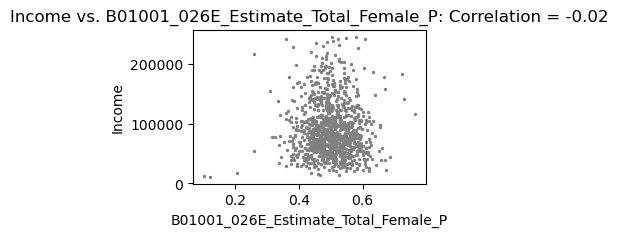

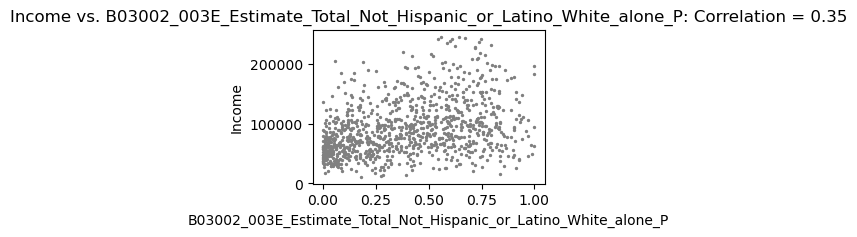

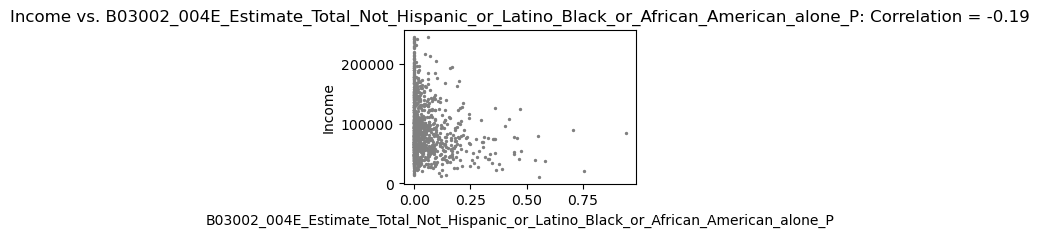

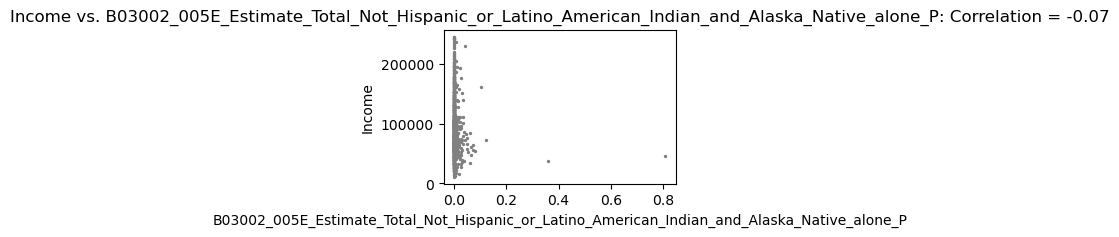

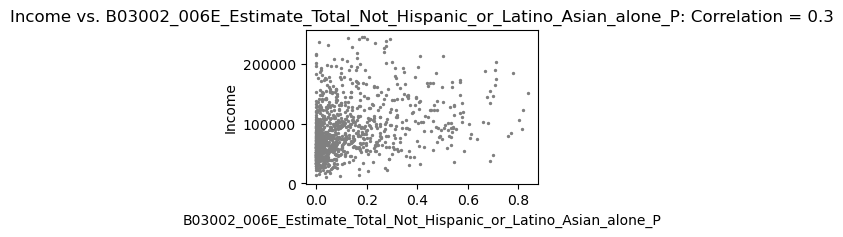

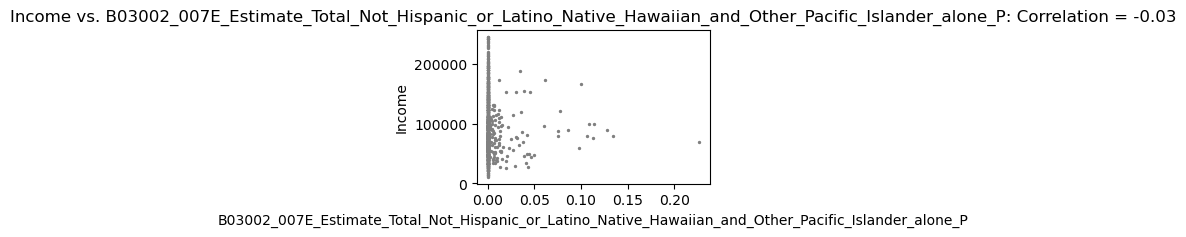

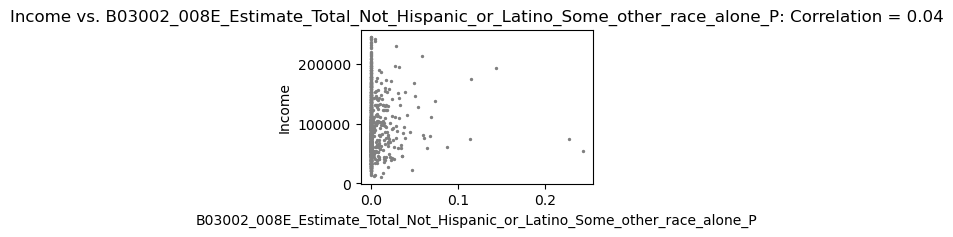

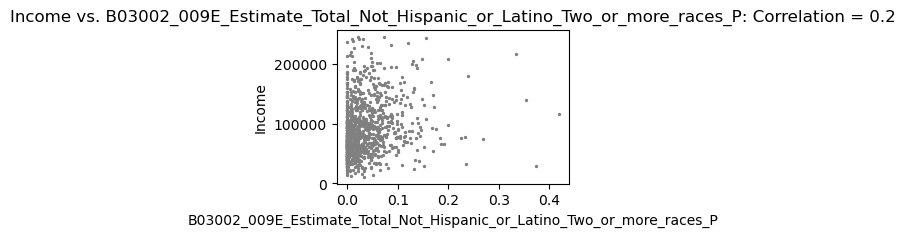

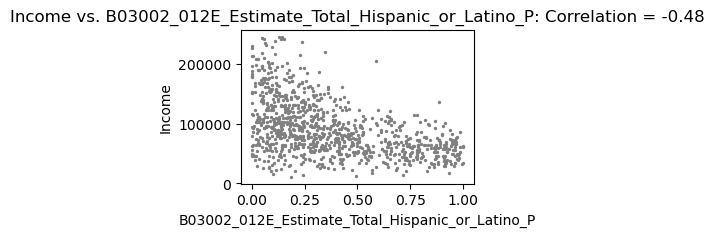

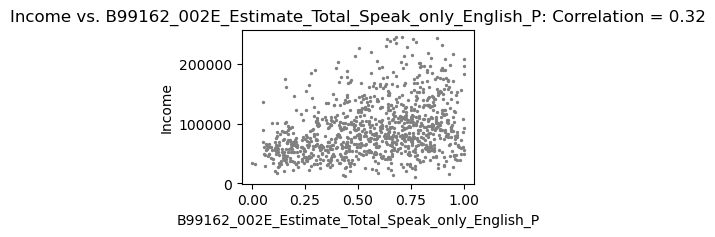

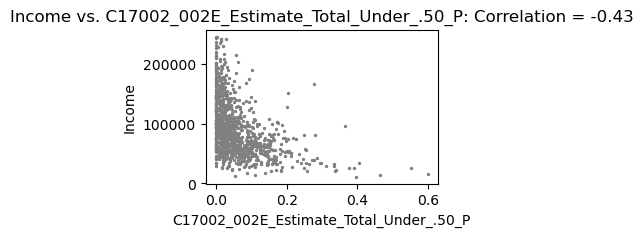

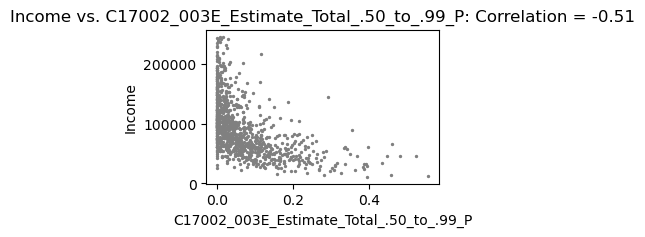

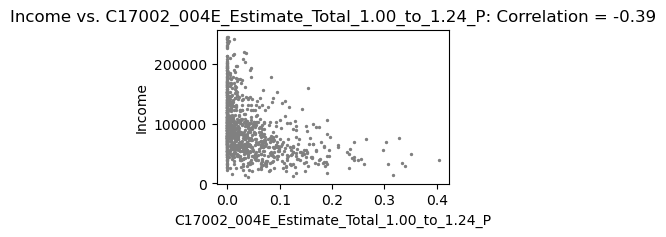

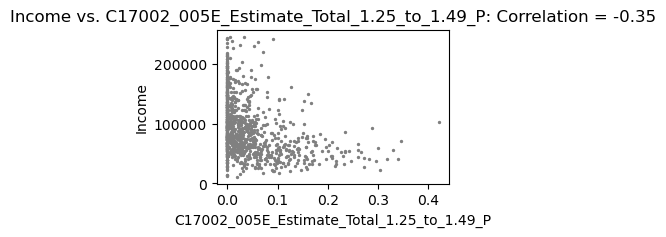

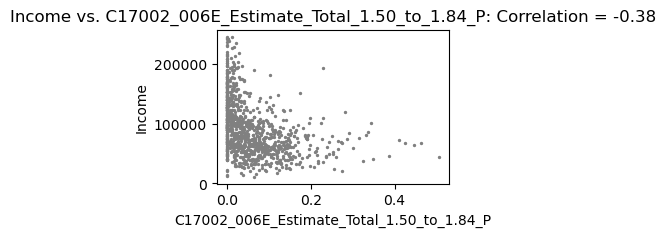

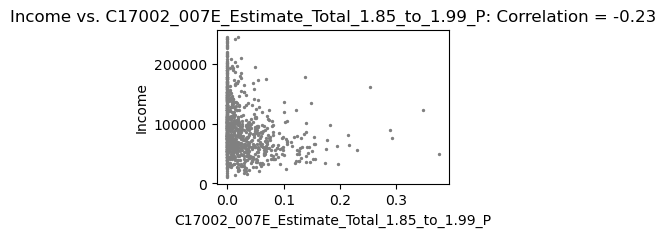

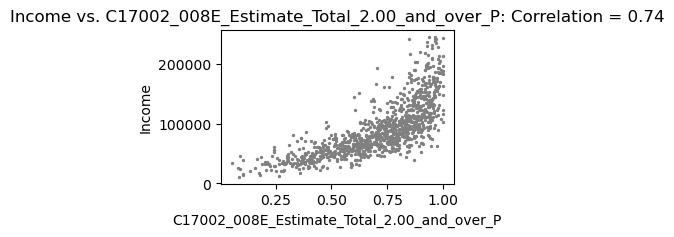

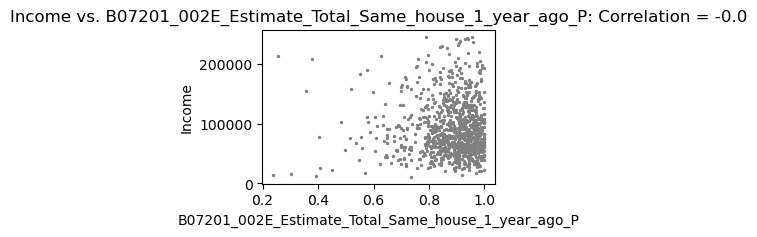

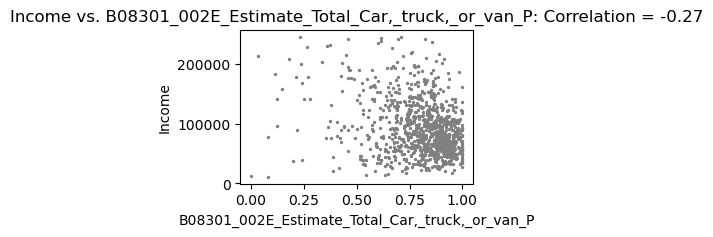

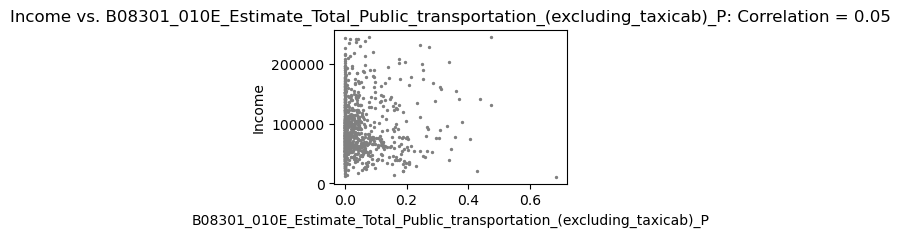

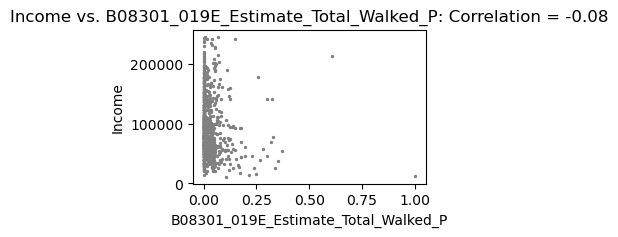

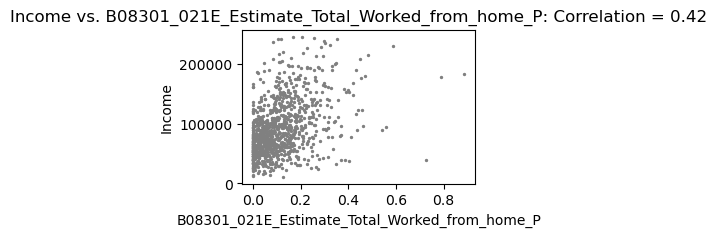

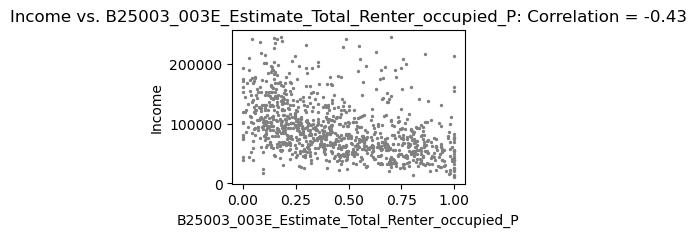

In [14]:
census_data_random_1000 = census_data_cleaned.sample(n=1000, random_state=1)
for i in features:
    fig = plt.figure(figsize=(3, 2))
    ax = fig.gca()
    feature = census_data_random_1000[i]
    lab = census_data_random_1000[label[0]]
    correlation = feature.corr(lab)
    plt.scatter(x=feature, y=lab, s=2, color='gray')
    plt.xlabel(i)
    plt.ylabel('Income')
    ax.set_title('Income vs. ' + i + ': Correlation = ' + str(correlation.round(2)))
plt.show()

Feature relationships with the label vary. As might be expected, the poverty features have the strongest correlations with median household income.

## Preprocess the Data

We will construct a scikit-learn pipeline for simplicity and replicability of preprocessing. To improve model performance, we will apply StandardScaler to scale the numeric features to have a zero-mean and unit variance. We will start by using basic linear regression.

In [15]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

Split the data into training and test sets using an 80/20 split.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(census_data_cleaned[features], census_data_cleaned[label], test_size=0.2, random_state=1)

## Run and Evaluate the Model

Fit the pipeline to the training set to standardize the features and run the model.

In [17]:
model = pipeline.fit(X_train, y_train)

Predict the labels for the test set.

In [18]:
predictions = model.predict(X_test)

Calculate model performance metrics.

In [19]:
print("MSE:", '{:.0f}'.format(mean_squared_error(y_test, predictions)))
print("RMSE:", '{:.0f}'.format(np.sqrt(mean_squared_error(y_test, predictions))))
print("R-Squared:", '{:.4f}'.format(r2_score(y_test, predictions)))

MSE: 754709681
RMSE: 27472
R-Squared: 0.6356


Create a scatterplot of the predicted and actual values.

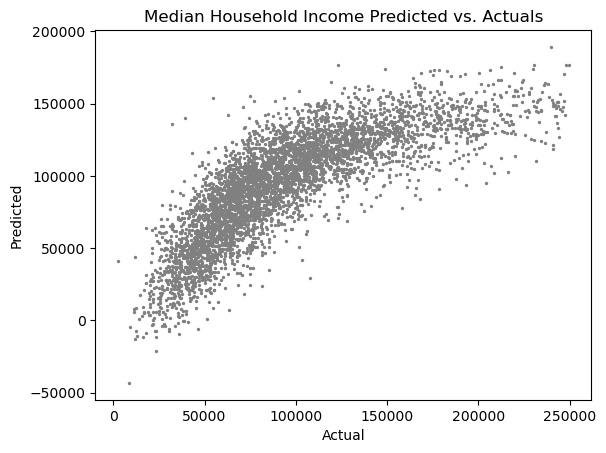

In [20]:
plt.scatter(y_test, predictions, s=2, color='gray')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Median Household Income Predicted vs. Actuals')
plt.show()

The predictions are better than chance, but could potentially be improved. We will run a couple of different models to see if we can improve model performance.

## Run and Evaluate Alternative Models

We will try some ensemble models, which may perform better than basic linear regression because they can model more complex relationships between features and the label.

In [21]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor())
])

model = pipeline.fit(X_train, y_train)

predictions = model.predict(X_test)

print("MSE:", '{:.0f}'.format(mean_squared_error(y_test, predictions)))
print("RMSE:", '{:.0f}'.format(np.sqrt(mean_squared_error(y_test, predictions))))
print("R-Squared:", '{:.4f}'.format(r2_score(y_test, predictions)))

/Users/ellie/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


MSE: 617606023
RMSE: 24852
R-Squared: 0.7018


In [22]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', GradientBoostingRegressor())
])

model = pipeline.fit(X_train, y_train)

predictions = model.predict(X_test)

print("MSE:", '{:.0f}'.format(mean_squared_error(y_test, predictions)))
print("RMSE:", '{:.0f}'.format(np.sqrt(mean_squared_error(y_test, predictions))))
print("R-Squared:", '{:.4f}'.format(r2_score(y_test, predictions)))

/Users/ellie/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE: 613230278
RMSE: 24763
R-Squared: 0.7039


As expected, the other models resulted in better performance. We will proceed with the GradientBoostingRegressor because it had slightly better performance than the RandomForestRegresor.

## Apply the Model to New Data

Pickle the file to efficiently save it for later use.

In [23]:
filename = './predict_household_income.pkl'
joblib.dump(model, filename)

['./predict_household_income.pkl']

Load the model and the new data to apply it to. Our new dataset will be the records that were missing income data.

In [24]:
loaded_model = joblib.load(filename)
X_new = census_data_new[features].copy()
results = loaded_model.predict(X_new)
X_new['predicted_income'] = results
X_new.head(3)

,B01002_001E_Estimate_Median_age_--_Total,B01001_026E_Estimate_Total_Female_P,B03002_003E_Estimate_Total_Not_Hispanic_or_Latino_White_alone_P,B03002_004E_Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone_P,B03002_005E_Estimate_Total_Not_Hispanic_or_Latino_American_Indian_and_Alaska_Native_alone_P,B03002_006E_Estimate_Total_Not_Hispanic_or_Latino_Asian_alone_P,B03002_007E_Estimate_Total_Not_Hispanic_or_Latino_Native_Hawaiian_and_Other_Pacific_Islander_alone_P,B03002_008E_Estimate_Total_Not_Hispanic_or_Latino_Some_other_race_alone_P,B03002_009E_Estimate_Total_Not_Hispanic_or_Latino_Two_or_more_races_P,B03002_012E_Estimate_Total_Hispanic_or_Latino_P,B99162_002E_Estimate_Total_Speak_only_English_P,C17002_002E_Estimate_Total_Under_.50_P,C17002_003E_Estimate_Total_.50_to_.99_P,C17002_004E_Estimate_Total_1.00_to_1.24_P,C17002_005E_Estimate_Total_1.25_to_1.49_P,C17002_006E_Estimate_Total_1.50_to_1.84_P,C17002_007E_Estimate_Total_1.85_to_1.99_P,C17002_008E_Estimate_Total_2.00_and_over_P,B07201_002E_Estimate_Total_Same_house_1_year_ago_P,"B08301_002E_Estimate_Total_Car,_truck,_or_van_P",B08301_010E_Estimate_Total_Public_transportation_(excluding_taxicab)_P,B08301_019E_Estimate_Total_Walked_P,B08301_021E_Estimate_Total_Worked_from_home_P,B25003_003E_Estimate_Total_Renter_occupied_P,predicted_income
6,51.3,0.512405,0.387405,0.312977,0.014313,0.145038,0.000000,0.0,0.101145,0.039122,0.813282,0.083969,0.027672,0.090649,0.051527,0.021947,0.015267,0.708969,0.883542,0.578231,0.197279,0.000000,0.167800,0.666667,70563.214606
29,29.9,0.525826,0.298052,0.071973,0.000000,0.046571,0.012701,0.0,0.032176,0.538527,0.370982,0.026361,0.048469,0.032313,0.020408,0.000000,0.000000,0.872449,0.857633,0.718539,0.216509,0.023004,0.000000,0.883382,84199.453412
68,65.2,0.374838,0.261997,0.417639,0.000000,0.224384,0.000000,0.0,0.095979,0.000000,0.888457,0.195850,0.130999,0.108949,0.029831,0.000000,0.000000,0.534371,0.638132,0.090278,0.430556,0.083333,0.302083,0.948339,38403.266737


## Useful Resources

https://learn.microsoft.com/en-us/training/modules/explore-analyze-data-with-python/5-exercise-visualize-data

https://learn.microsoft.com/en-us/training/modules/train-evaluate-regression-models/7-exercise-optimize-save-models

https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02

https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html